# Aing_리그전 Transformer Fine-tune 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aing-gachon/26-Spring-Transformer-Study/blob/main/Week3/Aing_%EB%A6%AC%EA%B7%B8%EC%A0%84_Transformer_Finetune_Multi30k_IWSLT.ipynb)

### STEP1. 설치 (Colab 기준)
- **목표:** Colab/Jupyter에서 필요한 라이브러리를 설치합니다.
- **왜 필요한가?**
  - `datasets`: HuggingFace에서 Multi30k/IWSLT 같은 데이터셋을 쉽게 불러옵니다.
  - `tokenizers`: BPE(서브워드) 토크나이저를 빠르게 학습/적용합니다.
  - `sacrebleu`: 번역 품질을 수치화하는 **BLEU** 점수를 계산합니다.

- **실행 팁:** 이 셀은 보통 **한 번만** 실행하면 됩니다(런타임 재시작하면 다시 실행).

In [ ]:
!pip -q install -U "transformers==5.2.0" "datasets==4.5.0" "accelerate==1.12.0" "tokenizers==0.22.2" sacrebleu

# 설치 후 import 에러가 나면 런타임 재시작(Runtime > Restart runtime) 후 다시 실행하세요.

### STEP2. import os, math, random, time
- **목표:** 번역 데이터셋을 로드하고(train/valid/test) 필요한 컬럼을 확인합니다.
- **핵심 로직:**
  - `load_dataset(...)` → `DatasetDict`(train/validation/test) 형태로 반환
  - 한 샘플은 보통 `{src_lang: ..., tgt_lang: ...}` 또는 `{'translation': {'de':..., 'en':...}}` 형태
- **용어:**
  - **train**: 학습용(가중치 업데이트)
  - **validation(dev)**: 튜닝/중간 평가용(가중치 업데이트 X)
  - **test**: 최종 평가용(리그전 점수)
- **실험 팁(120분):** train/valid/test 샘플 수를 줄이면 **여러 번 실험**하기 쉬워집니다.

In [ ]:
import os, math, random, time
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # tokenizer 병렬 경고/데드락 방지
from dataclasses import dataclass
from typing import Dict, Any, Optional

import numpy as np
import torch
import sacrebleu

from datasets import load_dataset, Dataset

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing

from transformers import (
    PreTrainedTokenizerFast,
    BartConfig,
    BartForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

def safe_load_dataset(*args, **kwargs):
    try:
        return load_dataset(*args, **kwargs)
    except Exception as e:
        if 'trust_remote_code' in str(e):
            return load_dataset(*args, trust_remote_code=True, **kwargs)
        raise

# === 공통 유틸: BPE 토크나이저 학습 / HF 토크나이저 래퍼 ===
SPECIAL_TOKENS = ["<pad>", "<bos>", "<eos>", "<unk>"]

def train_bpe_tokenizer(train_ds, vocab_size=8000, min_freq=2, src_key=None, tgt_key=None):
    if src_key is None:
        src_key = globals().get("SRC_KEY", "de")
    if tgt_key is None:
        tgt_key = globals().get("TGT_KEY", "en")

    tok = Tokenizer(BPE(unk_token="<unk>"))
    tok.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=min_freq,
        special_tokens=SPECIAL_TOKENS,
    )

    def iterator():
        for ex in train_ds:
            yield ex[src_key]
            yield ex[tgt_key]

    tok.train_from_iterator(iterator(), trainer=trainer)

    bos_id = tok.token_to_id("<bos>")
    eos_id = tok.token_to_id("<eos>")
    tok.post_processor = TemplateProcessing(
        single="<bos> $A <eos>",
        special_tokens=[("<bos>", bos_id), ("<eos>", eos_id)],
    )
    return tok

def build_hf_tokenizer_from_tokenizers(tok: Tokenizer) -> PreTrainedTokenizerFast:
    return PreTrainedTokenizerFast(
        tokenizer_object=tok,
        bos_token="<bos>",
        eos_token="<eos>",
        unk_token="<unk>",
        pad_token="<pad>",
    )


### STEP3. def set_seed(seed=42):
- **목표:** 실험이 매번 조금씩 달라지는 현상을 줄이기 위해 **난수 시드(seed)** 를 고정하고, GPU/CPU 디바이스를 설정합니다.
- **핵심 로직:**
  1) `random`, `numpy`, `torch`의 seed를 동일하게 설정
  2) `cuda` 사용 가능하면 GPU로 학습 (속도↑)
- **용어:**
  - **재현성(reproducibility)**: 같은 코드/데이터로 같은 결과가 나오게 하는 성질(리그전에서 중요).

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

def make_seq2seq_training_args(**kwargs):
    try:
        return Seq2SeqTrainingArguments(**kwargs)
    except TypeError:
        # 가장 흔한 변경: eval_strategy ↔ evaluation_strategy
        if "eval_strategy" in kwargs and "evaluation_strategy" not in kwargs:
            kwargs["evaluation_strategy"] = kwargs.pop("eval_strategy")
        elif "evaluation_strategy" in kwargs and "eval_strategy" not in kwargs:
            kwargs["eval_strategy"] = kwargs.pop("evaluation_strategy")
        return Seq2SeqTrainingArguments(**kwargs)


device: cuda


## 1) Multi30k 로드 & 토크나이저 학습

- Stage 1/2에서 **같은 토크나이저**를 쓰는 편이 실험이 단순해집니다.
- Multi30k로 BPE를 학습한 뒤, IWSLT에도 그대로 적용합니다.

### STEP4. Stage 0: Multi30k 로드 (tokenizer 학습/기본 학습용)
- **목표:** 번역 데이터셋을 로드하고(train/valid/test) 필요한 컬럼을 확인합니다.
- **핵심 로직:**
  - `load_dataset(...)` → `DatasetDict`(train/validation/test) 형태로 반환
  - 한 샘플은 보통 `{src_lang: ..., tgt_lang: ...}` 또는 `{'translation': {'de':..., 'en':...}}` 형태
- **용어:**
  - **train**: 학습용(가중치 업데이트)
  - **validation(dev)**: 튜닝/중간 평가용(가중치 업데이트 X)
  - **test**: 최종 평가용(리그전 점수)
- **실험 팁(120분):** train/valid/test 샘플 수를 줄이면 **여러 번 실험**하기 쉬워집니다.

In [ ]:
multi30k = safe_load_dataset("bentrevett/multi30k")
SRC_KEY = "de"
TGT_KEY = "en"

train_m30k = multi30k["train"]
valid_m30k = multi30k["validation"]
test_m30k  = multi30k["test"]

# === (고정) 데이터 사용 규칙 ===
M30K_TRAIN_SAMPLES_FIXED = 20_000   # 고정: 학습 속도용 subset
# valid/test는 전체 사용

train_m30k = train_m30k.select(range(min(M30K_TRAIN_SAMPLES_FIXED, len(train_m30k))))

print("Multi30k sizes:", len(train_m30k), len(valid_m30k), len(test_m30k))
print("sample:", train_m30k[0])


29000 300 300
{'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}


### STEP5. 토크나이저(BPE) 학습: Multi30k train 기반

- **목표:** 텍스트를 모델 입력으로 바꾸는 **토크나이저(tokenizer)** 를 준비합니다. 여기서는 **BPE(Byte Pair Encoding)** 서브워드 방식을 사용합니다.
- **핵심 로직:**
  1) `SPECIAL_TOKENS`(<pad>, <bos>, <eos>, <unk>) 정의
  2) Multi30k train 텍스트로 BPE 학습
  3) 학습된 tokenizer로 텍스트→ID 시퀀스 변환
- **용어:**
  - **vocab(어휘집)**: 토큰 ID로 변환 가능한 토큰들의 집합
  - **subword(서브워드)**: 단어를 더 작은 조각으로 쪼갠 토큰(희귀 단어 처리에 강함)
  - **<unk>**: vocab에 없는 토큰(OOV)을 대체하는 토큰

- **리그전 규칙(고정)**
  - 이번 리그전에서는 토크나이저 관련 설정(`VOCAB_SIZE`, `min_freq`, `MAX_LEN`)을 **고정**합니다.  
    튜닝 축을 줄여서 **모델 구조 + fine-tune 학습 설정**에 집중하기 위함입니다.


In [ ]:
assert "train_bpe_tokenizer" in globals(), "train_bpe_tokenizer가 없습니다. 위의 import/유틸(토크나이저) 셀을 먼저 실행하세요."
assert "build_hf_tokenizer_from_tokenizers" in globals(), "build_hf_tokenizer_from_tokenizers가 없습니다. 위의 import/유틸(토크나이저) 셀을 먼저 실행하세요."

# === 토크나이저(BPE) 학습: Multi30k train 기반 ===
# (고정) 리그전에서는 토크나이저 설정을 변경하지 않습니다.

VOCAB_SIZE_FIXED = 8000
MIN_FREQ_FIXED = 2
MAX_LEN_FIXED = 64 

tok = train_bpe_tokenizer(train_m30k, vocab_size=VOCAB_SIZE_FIXED, min_freq=MIN_FREQ_FIXED)

hf_tokenizer = build_hf_tokenizer_from_tokenizers(tok)

MAX_LEN = MAX_LEN_FIXED 

print("vocab_size:", hf_tokenizer.vocab_size)
print("special tokens:", hf_tokenizer.special_tokens_map)


vocab_size: 8000


### (추가) Multi30k 토크나이징 예시 시각화
- **목표:** 학습/평가 과정을 눈으로 확인하기 위한 보조 시각화입니다.
- **참고:** 리그전 튜닝은 상단의 `MODEL_HP`(구조)와 `FT_HP`(fine-tune 학습 설정)에서만 진행합니다.


In [27]:
# === (추가) Multi30k 토크나이징 예시 ===
ex = multi30k["train"][0]
print("SRC:", ex[SRC_KEY])
print("TGT:", ex[TGT_KEY])

enc = hf_tokenizer(ex[SRC_KEY])
print("input_ids[:20]:", enc["input_ids"][:20])
print("tokens[:20]:", hf_tokenizer.convert_ids_to_tokens(enc["input_ids"][:20]))


SRC: Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
TGT: Two young, White males are outside near many bushes.
input_ids[:20]: [1, 214, 544, 1392, 306, 708, 168, 743, 103, 145, 839, 1662, 105, 813, 2370, 15, 2]
tokens[:20]: ['<bos>', 'Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'viel', 'er', 'Bü', 'sche', '.', '<eos>']


### STEP6. 공통 전처리 함수
- **목표:** HuggingFace `datasets` 형식의 예제를 모델 학습용 텐서 컬럼으로 변환합니다.
- **핵심 로직:**
  - `input_ids`: 소스 문장 토큰 ID
  - `labels`: 타깃 문장 토큰 ID (학습 시 정답)
  - `max_length`/`truncation`으로 길이를 통제합니다.
- **용어:**
  - **labels**: 분류/번역에서 정답을 의미. Seq2Seq에서는 '다음 토큰' 정답열입니다.
  - **ignore_index(-100)**: loss 계산에서 무시할 위치(보통 padding)를 표시하는 값(HF Trainer가 사용).

In [28]:
# === 공통 전처리 함수 ===
def preprocess_m30k(examples):
    model_inputs = hf_tokenizer(examples[SRC_KEY], max_length=MAX_LEN, truncation=True)
    labels = hf_tokenizer(text_target=examples[TGT_KEY], max_length=MAX_LEN, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_m30k_tok = train_m30k.map(preprocess_m30k, batched=True, remove_columns=train_m30k.column_names)
valid_m30k_tok = valid_m30k.map(preprocess_m30k, batched=True, remove_columns=valid_m30k.column_names)
test_m30k_tok  = test_m30k.map(preprocess_m30k,  batched=True, remove_columns=test_m30k.column_names)

train_m30k_tok[0]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

{'input_ids': [1,
  214,
  544,
  1392,
  306,
  708,
  168,
  743,
  103,
  145,
  839,
  1662,
  105,
  813,
  2370,
  15,
  2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [1, 217, 273, 13, 5008, 3650, 192, 479, 581, 1788, 5743, 15, 2]}

### STEP7. 모델

- **목표:** HuggingFace `transformers`의 **Encoder-Decoder Transformer** 모델을 작은 설정으로 '처음부터(from scratch)' 만듭니다.
- **핵심 로직:**
  - `d_model`, `num_layers`, `nhead`, `d_ff`, `dropout` 같은 구조 하이퍼파라미터를 `Config`에 매핑합니다.
  - `vocab_size`는 우리가 학습한 BPE tokenizer에 맞춥니다.
- **리그전 튜닝(허용)**
  - 이 STEP에서는 **Model(구조) 하이퍼파라미터**만 튜닝합니다.  
    (코드에서 `MODEL_HP`의 `🔧 TUNE` 값만 수정)

- **🔧 TUNE 포인트**
  - `d_model` / `nhead` / `num_layers` / `d_ff` / `dropout`


In [ ]:
# === 모델 ===
# 리그전에서 바꿔도 되는 값(1): Model(구조) 하이퍼파라미터
# 아래 MODEL_HP 딕셔너리의 값만 `🔧 TUNE`로 표시되어 있습니다.

MODEL_HP = dict(
    d_model=128,     # 🔧 TUNE: 128 -> 256 -> 384 ...
    nhead=4,         # 🔧 TUNE: d_model % nhead == 0 필수
    num_layers=2,    # 🔧 TUNE: 2 -> 3 -> 4 ...
    d_ff=512,        # 🔧 TUNE: 보통 2~4 × d_model (예: 512~1024)
    dropout=0.30,    # 🔧 TUNE: 0.1~0.3 범위에서 탐색
)

def build_model(d_model, nhead, num_layers, d_ff, dropout):
    # 안전장치: head 제약
    assert d_model % nhead == 0, f"d_model({d_model}) must be divisible by nhead({nhead})"

    config = BartConfig(
        vocab_size=hf_tokenizer.vocab_size,
        d_model=d_model,
        encoder_layers=num_layers,
        decoder_layers=num_layers,
        encoder_attention_heads=nhead,
        decoder_attention_heads=nhead,
        encoder_ffn_dim=d_ff,
        decoder_ffn_dim=d_ff,
        dropout=dropout,
        attention_dropout=dropout,
        activation_dropout=dropout,
        max_position_embeddings=MAX_LEN + 2,
        pad_token_id=hf_tokenizer.pad_token_id,
        bos_token_id=hf_tokenizer.bos_token_id,
        eos_token_id=hf_tokenizer.eos_token_id,
        decoder_start_token_id=hf_tokenizer.bos_token_id,
        attn_implementation="eager", 
    )
    return BartForConditionalGeneration(config)

model = build_model(**MODEL_HP)
print("model params (M):", sum(p.numel() for p in model.parameters()) / 1e6)


7.61344

### STEP8. BLEU metric
- **목표:** 번역 품질을 BLEU로 평가하는 함수를 정의합니다.
- **BLEU가 뭐예요?**
  - 모델 번역(hypothesis)과 정답(reference) 사이의 n-gram 겹침을 기반으로 하는 점수입니다.
  - 높을수록 좋지만, 사람 평가와 100% 일치하진 않습니다(그래도 리그전 지표로 많이 씀).
- **주의:**
  - 토크나이징 방식(BPE/공백), 특수토큰 제거 여부에 따라 BLEU가 달라질 수 있어요.

In [ ]:
import re

_detok_punct_re = re.compile(r"\s+([?.!,;:])")
_detok_contraction_re = re.compile(r"\s+(n't|'re|'ve|'ll|'d|'m|'s)\b")

def simple_detokenize(text: str) -> str:
    text = text.strip()
    text = _detok_punct_re.sub(r"\1", text)
    text = _detok_contraction_re.sub(r"\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def compute_metrics(eval_pred):
    # transformers 버전에 따라 eval_pred가 (preds, labels) 튜플이거나 EvalPrediction일 수 있음
    preds = eval_pred.predictions if hasattr(eval_pred, "predictions") else eval_pred[0]
    labels = eval_pred.label_ids if hasattr(eval_pred, "label_ids") else eval_pred[1]

    # tuple(preds, ..) 형태로 오는 경우가 있음
    if isinstance(preds, tuple):
        preds = preds[0]

    pad_id = hf_tokenizer.pad_token_id
    unk_id = hf_tokenizer.unk_token_id if hf_tokenizer.unk_token_id is not None else pad_id

    # ✅ v5: -100 padding 제거 (중요!)
    preds  = np.where(preds  != -100, preds,  pad_id)
    labels = np.where(labels != -100, labels, pad_id)

    # 추가 안전장치: vocab 범위를 벗어나면 unk로 치환
    preds  = np.where((preds  < 0) | (preds  >= hf_tokenizer.vocab_size), unk_id, preds)
    labels = np.where((labels < 0) | (labels >= hf_tokenizer.vocab_size), unk_id, labels)

    pred_str  = hf_tokenizer.batch_decode(preds,  skip_special_tokens=True)
    label_str = hf_tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ✅ detokenize + strip
    pred_str  = [simple_detokenize(p) for p in pred_str]
    label_str = [simple_detokenize(l) for l in label_str]

    # force=True: "토큰화된 것 같다"는 경고를 억제(우리는 위에서 detokenize도 수행)
    bleu = sacrebleu.corpus_bleu(pred_str, [label_str], force=True).score
    return {"bleu": bleu}


### STEP9. Stage A: Pre-train (Multi30k, 고정 설정)

- **목표:** Multi30k에서 기본 번역 능력을 먼저 학습합니다.
- **중요:** 리그전에서는 Pre-train의 학습 하이퍼파라미터를 **고정**합니다.  
  (실험 축을 줄이고, “Fine-tune 튜닝”에 집중하기 위함)

- **고정되는 것(예시)**
  - `PRETRAIN_MAX_STEPS_FIXED`, `PRETRAIN_LR_FIXED`, `PRETRAIN_WARMUP_FIXED`
  - batch size/accumulation
  - scheduler type, beam size 등

- **튜닝 가능한 것**
  - Pre-train 단계에서는 **Model(구조) 하이퍼파라미터**만 간접적으로 영향이 있습니다.  
    (같은 고정 설정으로 학습하더라도 모델 구조가 달라지면 결과가 달라짐)


In [ ]:
# === Stage A: Pre-train on Multi30k (고정 하이퍼파라미터) ===
# (고정) 리그전에서는 Pre-train 설정을 변경하지 않습니다.

from datetime import datetime
PRETRAIN_RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
PRETRAIN_OUT_DIR = f"./runs/league_pretrain_multi30k_{PRETRAIN_RUN_TAG}"

# === (고정) Pre-train 하이퍼파라미터 ===
PRETRAIN_MAX_STEPS_FIXED = 600
PRETRAIN_LR_FIXED = 5e-4
PRETRAIN_WARMUP_FIXED = 100
PRETRAIN_SCHEDULER_FIXED = "inverse_sqrt"

# (고정) 배치 관련: 메모리 안정성을 위해 작은 배치 + 누적
PRETRAIN_BSZ_FIXED = 16
PRETRAIN_ACCUM_FIXED = 2  # effective batch = 32

# (고정) 디코딩/평가 설정
GEN_BEAMS_FIXED = 4

pre_args = make_seq2seq_training_args(
    output_dir=PRETRAIN_OUT_DIR,
    max_steps=PRETRAIN_MAX_STEPS_FIXED,
    logging_steps=50,
    eval_steps=200,
    eval_strategy="steps",        # 중요: train() 중 eval이 돌아야 log_history에 eval_bleu가 쌓입니다.

    save_steps=10**9,           
    save_total_limit=1,

    per_device_train_batch_size=PRETRAIN_BSZ_FIXED,
    per_device_eval_batch_size=PRETRAIN_BSZ_FIXED,
    gradient_accumulation_steps=PRETRAIN_ACCUM_FIXED,

    learning_rate=PRETRAIN_LR_FIXED,
    lr_scheduler_type=PRETRAIN_SCHEDULER_FIXED,
    warmup_steps=PRETRAIN_WARMUP_FIXED,

    predict_with_generate=True,
    generation_max_length=MAX_LEN,
    generation_num_beams=GEN_BEAMS_FIXED,

    fp16=torch.cuda.is_available(),
    report_to=[],
)

collator = DataCollatorForSeq2Seq(hf_tokenizer, model=model)

try:
    pre_trainer = Seq2SeqTrainer(
        model=model,
        args=pre_args,
        train_dataset=train_m30k_tok,
        eval_dataset=valid_m30k_tok,
        processing_class=hf_tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )
except TypeError:
    pre_trainer = Seq2SeqTrainer(
        model=model,
        args=pre_args,
        train_dataset=train_m30k_tok,
        eval_dataset=valid_m30k_tok,
        tokenizer=hf_tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

pre_train_result = pre_trainer.train()
pre_valid = pre_trainer.evaluate()
print("pre_valid:", pre_valid)

pre_log_history = pre_trainer.state.log_history


Step,Training Loss
50,8.321957
100,6.241525
150,4.930811
200,4.432332
250,4.017784
300,3.778499
350,3.604947
400,3.496053
450,3.361637
500,3.240613


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

pre_train_result: TrainOutput(global_step=1200, training_loss=3.5405131085713704, metrics={'train_runtime': 85.9729, 'train_samples_per_second': 446.653, 'train_steps_per_second': 13.958, 'total_flos': 38758347522048.0, 'train_loss': 3.5405131085713704, 'epoch': 1.3230429988974641})
pre_valid: {'eval_loss': 2.3405346870422363, 'eval_bleu': 26.429961585849703, 'eval_runtime': 2.742, 'eval_samples_per_second': 109.408, 'eval_steps_per_second': 3.647, 'epoch': 1.3230429988974641}
pre_test: {'test_loss': 2.296957015991211, 'test_bleu': 26.3369219567465, 'test_runtime': 2.8323, 'test_samples_per_second': 105.92, 'test_steps_per_second': 3.531, 'epoch': 1.3230429988974641}


### (추가) Stage1(Pre-train) 로그 곡선 시각화
- **목표:** 학습/평가 과정을 눈으로 확인하기 위한 보조 시각화입니다.
- **참고:** 리그전 튜닝은 상단의 `MODEL_HP`(구조)와 `FT_HP`(fine-tune 학습 설정)에서만 진행합니다.


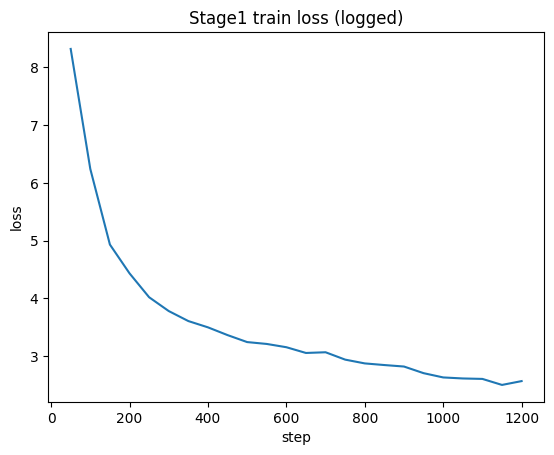

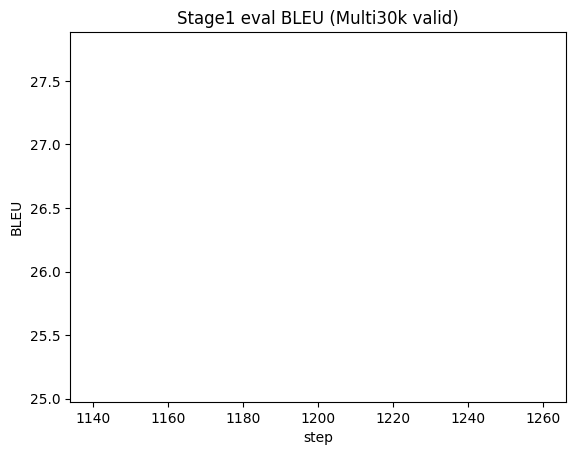

Stage1 last eval BLEU: 26.429961585849703


In [ ]:
import matplotlib.pyplot as plt

steps=[]; loss=[]
eval_steps=[]; eval_bleu=[]
for row in pre_log_history:
    if "loss" in row and "step" in row:
        steps.append(row["step"]); loss.append(row["loss"])
    if "eval_bleu" in row and "step" in row:
        eval_steps.append(row["step"]); eval_bleu.append(row["eval_bleu"])

if len(loss)>0:
    plt.figure()
    plt.plot(steps, loss, marker="o")
    plt.title("Stage1 train loss (logged)")
    plt.xlabel("step"); plt.ylabel("loss")
    plt.grid(True, alpha=0.3)
    plt.show()

if len(eval_bleu)>0:
    plt.figure()
    plt.plot(eval_steps, eval_bleu, marker="o")
    plt.title("Stage1 eval BLEU (Multi30k valid)")
    plt.xlabel("step"); plt.ylabel("BLEU")
    plt.grid(True, alpha=0.3)
    plt.show()

# Stage1 점수는 리그전 최종 점수가 아닙니다(참고용).
stage1_last_logged = eval_bleu[-1] if len(eval_bleu)>0 else None
stage1_eval_after  = pre_valid.get("eval_bleu") if isinstance(pre_valid, dict) else None

print("Stage1 last logged eval BLEU (during train):", stage1_last_logged)
print("Stage1 eval BLEU (after train, pre_trainer.evaluate):", stage1_eval_after)


### (추가) Stage1 번역 예시 시각화
- **목표:** 학습/평가에 필요한 패키지를 import 합니다.
- **핵심 로직:**
  - PyTorch(`torch`): 모델/텐서/학습 루프
  - HuggingFace `datasets`: 데이터 로드
  - `tokenizers`: BPE 토크나이저
  - `sacrebleu`: BLEU 평가
- **용어:**
  - **모듈(module)**: 파이썬 파일/라이브러리 단위. 필요한 기능을 가져와 씁니다.

In [33]:
# === (추가) Stage1 번역 예시 ===
import torch

model.eval()
for i in range(3):
    ex = multi30k["validation"][i]
    src_text = ex[SRC_KEY]
    ref_text = ex[TGT_KEY]

    inputs = hf_tokenizer(src_text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)
    gen_ids = model.generate(**inputs, max_length=MAX_LEN, num_beams=4)
    hyp_text = hf_tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print("\n--- example", i, "---")
    print("SRC:", src_text)
    print("REF:", ref_text)
    print("HYP:", hyp_text)



--- example 0 ---
SRC: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
REF: A group of men are loading cotton onto a truck
HYP: A group of men are drinking a tree .

--- example 1 ---
SRC: Ein Mann schläft in einem grünen Raum auf einem Sofa.
REF: A man sleeping in a green room on a couch.
HYP: A man is sleeping in a green room .

--- example 2 ---
SRC: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
REF: A boy wearing headphones sits on a woman's shoulders.
HYP: A boy with her hair is sitting on a woman .


### STEP10. Stage B: Fine-tune (IWSLT, 튜닝 대상)

- **목표:** Pre-train된 모델을 시작점으로 IWSLT 데이터로 미세조정합니다.
- **리그전 튜닝 범위**
  - **Model(구조) 하이퍼파라미터** (상단 MODEL_HP)
  - **Fine-tune Optimizer/Schedule 하이퍼파라미터** (아래 FT_HP)
- **고정**
  - Fine-tune 데이터셋(IWSLT), 데이터 샘플링, batch size/accumulation, step budget, 디코딩 설정 등


In [ ]:
# === (고정) Fine-tune 데이터 사용 규칙 ===
IWSLT_TRAIN_SAMPLES_FIXED = 50_000
IWSLT_SHUFFLE_SEED_FIXED = 42

def load_iwslt2017_de_en_parquet():
    """IWSLT 2017 (de-en) parquet 직접 로드."""
    REV = "b2dcd74c28e4544eb5c9bb76ace449ea26bbe909"
    base = f"https://huggingface.co/datasets/IWSLT/iwslt2017/resolve/{REV}/iwslt2017-de-en"

    data_files = {
        "train": f"{base}/iwslt2017-train.parquet",
        "validation": f"{base}/iwslt2017-validation.parquet",
        "test": f"{base}/iwslt2017-test.parquet",
    }
    return load_dataset("parquet", data_files=data_files)

ft_raw = load_iwslt2017_de_en_parquet()
ft_raw


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 206112
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 888
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 8079
    })
})

### STEP11. Fine-tune 전처리

- **목표:** IWSLT 데이터셋의 예제를 모델 학습용 텐서 컬럼으로 변환합니다.
- **핵심 로직:**
  - `input_ids`: 소스 문장 토큰 ID
  - `labels`: 타깃 문장 토큰 ID (학습 시 정답)
  - `max_length`/`truncation`으로 길이를 통제합니다.
- **용어:**
  - **labels**: 번역에서 정답 토큰열(다음 토큰 예측)
  - **ignore_index(-100)**: loss 계산에서 무시할 위치(보통 padding).  
    HF Trainer가 내부적으로 사용하며, metric 계산 전에 -100을 pad로 바꿔야 합니다(OverflowError 방지).

- **리그전 규칙(고정)**
  - Fine-tune 데이터셋(IWSLT) 및 샘플링/셔플 규칙은 **고정**입니다.


In [35]:
# === Fine-tune 전처리 (IWSLT 고정) ===
import json

def preprocess_translation_dict(examples, src_lang="de", tgt_lang="en"):
    """translation 필드(dict 또는 JSON string)를 (input_ids, labels)로 변환합니다."""
    trans = examples["translation"]

    src_texts, tgt_texts = [], []
    for ex in trans:
        if isinstance(ex, str):
            try:
                ex = json.loads(ex)
            except Exception:
                ex = {}

        if isinstance(ex, dict):
            src_texts.append(ex.get(src_lang, ""))
            tgt_texts.append(ex.get(tgt_lang, ""))
        else:
            src_texts.append("")
            tgt_texts.append("")

    model_inputs = hf_tokenizer(src_texts, max_length=MAX_LEN, truncation=True)

    try:
        labels = hf_tokenizer(text_target=tgt_texts, max_length=MAX_LEN, truncation=True)
    except TypeError:
        with hf_tokenizer.as_target_tokenizer():
            labels = hf_tokenizer(tgt_texts, max_length=MAX_LEN, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# (고정) IWSLT train만 subset, valid/test는 전체 사용
ft_train = ft_raw["train"].shuffle(seed=IWSLT_SHUFFLE_SEED_FIXED).select(
    range(min(IWSLT_TRAIN_SAMPLES_FIXED, len(ft_raw["train"])))
)
ft_valid = ft_raw["validation"]
ft_test  = ft_raw["test"]

ft_train_tok = ft_train.map(lambda x: preprocess_translation_dict(x, "de", "en"), batched=True, remove_columns=ft_train.column_names)
ft_valid_tok = ft_valid.map(lambda x: preprocess_translation_dict(x, "de", "en"), batched=True, remove_columns=ft_valid.column_names)
ft_test_tok  = ft_test.map(lambda x: preprocess_translation_dict(x, "de", "en"),  batched=True, remove_columns=ft_test.column_names)

print("IWSLT prepared:", len(ft_train_tok), len(ft_valid_tok), len(ft_test_tok))


prepared finetune dataset


### STEP12. Stage B: Fine-tune (튜닝 구간)

- **목표:** IWSLT로 fine-tune을 수행한 뒤, **Multi30k test BLEU**를 최종 점수로 출력합니다.
- **핵심 로직:**
  - 학습은 IWSLT(train subset)로 진행
  - 평가는 Multi30k(valid/test)로 진행(최종 점수 도메인 고정)
  - 마지막에 `FINAL_TEST_BLEU`와 `RUN SUMMARY(JSON)`를 출력합니다.

- **리그전 튜닝(허용)**
  - Model(구조): `MODEL_HP` (STEP7)
  - Fine-tune Optimizer/Schedule: `FT_HP` (이 STEP 코드 셀)
- **고정**
  - fine-tune step budget, batch size/accumulation, 디코딩(beam), MAX_LEN 등은 **고정**


In [ ]:
# === Stage B: Fine-tune (🔧 TUNE: optimizer/schedule만) ===
# 리그전에서 바꿔도 되는 값(2): Fine-tune Optimizer / Schedule 하이퍼파라미터
# 아래 FT_HP 딕셔너리만 `🔧 TUNE`로 표시되어 있습니다.

FT_HP = dict(
    learning_rate=1e-4,            # 🔧 TUNE: 5e-5 ~ 5e-4
    lr_scheduler_type="linear",    # 🔧 TUNE: linear / cosine / inverse_sqrt
    warmup_steps=50,               # 🔧 TUNE: 0 ~ 200
    weight_decay=0.0,              # 🔧 TUNE: 0.0 ~ 0.1
    label_smoothing_factor=0.2,    # 🔧 TUNE: 0.0 ~ 0.2
)

# (고정) Fine-tune 예산/배치/디코딩은 변경하지 않습니다.
FINETUNE_MAX_STEPS_FIXED = 500
FINETUNE_BSZ_FIXED = 16
FINETUNE_ACCUM_FIXED = 2   # effective batch = 32
GEN_BEAMS_FIXED = 4

from datetime import datetime
FT_RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
FT_OUT_DIR = f"./runs/league_finetune_iwslt_{FT_RUN_TAG}"

ft_args = make_seq2seq_training_args(
    output_dir=FT_OUT_DIR,
    max_steps=FINETUNE_MAX_STEPS_FIXED,
    logging_steps=50,
    eval_steps=200,
    eval_strategy="steps",        
    save_steps=10**9,          
    save_total_limit=1,

    per_device_train_batch_size=FINETUNE_BSZ_FIXED,
    per_device_eval_batch_size=FINETUNE_BSZ_FIXED,
    gradient_accumulation_steps=FINETUNE_ACCUM_FIXED,

    learning_rate=FT_HP["learning_rate"],
    lr_scheduler_type=FT_HP["lr_scheduler_type"],
    warmup_steps=FT_HP["warmup_steps"],
    weight_decay=FT_HP["weight_decay"],
    label_smoothing_factor=FT_HP["label_smoothing_factor"],

    predict_with_generate=True,
    generation_max_length=MAX_LEN,
    generation_num_beams=GEN_BEAMS_FIXED,

    fp16=torch.cuda.is_available(),
    report_to=[],
)

try:
    ft_trainer = Seq2SeqTrainer(
        model=model,  # Stage A에서 학습된 동일 모델을 이어서 사용
        args=ft_args,
        train_dataset=ft_train_tok,
        # (고정) 평가 기준은 Multi30k valid로 통일(최종 점수 도메인)
        eval_dataset=valid_m30k_tok,
        processing_class=hf_tokenizer,
        data_collator=DataCollatorForSeq2Seq(hf_tokenizer, model=model),
        compute_metrics=compute_metrics,
    )
except TypeError:
    ft_trainer = Seq2SeqTrainer(
        model=model,
        args=ft_args,
        train_dataset=ft_train_tok,
        eval_dataset=valid_m30k_tok,
        tokenizer=hf_tokenizer,
        data_collator=DataCollatorForSeq2Seq(hf_tokenizer, model=model),
        compute_metrics=compute_metrics,
    )

ft_train_result = ft_trainer.train()

# Fine-tune 후: Multi30k valid/test로 최종 점수 산출
ft_m30k_valid = ft_trainer.evaluate(eval_dataset=valid_m30k_tok, metric_key_prefix="m30k_valid")
ft_m30k_test  = ft_trainer.evaluate(eval_dataset=test_m30k_tok,  metric_key_prefix="m30k_test")

FINAL_TEST_BLEU = (ft_m30k_test.get("m30k_test_bleu") if isinstance(ft_m30k_test, dict) else None)
print("FINAL_TEST_BLEU:", FINAL_TEST_BLEU)

# 리그전 최종 점수(LeaderBoard)는 아래 값을 사용합니다.
print("\n=== LEAGUE FINAL SCORE (after fine-tune) ===")
print("LEAGUE_FINAL_SCORE_M30K_TEST_BLEU:", FINAL_TEST_BLEU)

import json
run_summary = {
    "time": datetime.now().isoformat(timespec="seconds"),
    "score_metric": "BLEU (Multi30k test after fine-tune)",
    "FINAL_TEST_BLEU": FINAL_TEST_BLEU,
    "MODEL_HP": MODEL_HP,
    "FT_HP": FT_HP,
    "fixed": {
        "MAX_LEN": MAX_LEN,
        "VOCAB_SIZE": VOCAB_SIZE_FIXED,
        "M30K_TRAIN_SAMPLES": M30K_TRAIN_SAMPLES_FIXED,
        "IWSLT_TRAIN_SAMPLES": IWSLT_TRAIN_SAMPLES_FIXED,
        "PRETRAIN_MAX_STEPS": PRETRAIN_MAX_STEPS_FIXED,
        "FINETUNE_MAX_STEPS": FINETUNE_MAX_STEPS_FIXED,
        "GEN_BEAMS": GEN_BEAMS_FIXED,
        "BATCH": {
            "PRETRAIN": {"bsz": PRETRAIN_BSZ_FIXED, "accum": PRETRAIN_ACCUM_FIXED},
            "FINETUNE": {"bsz": FINETUNE_BSZ_FIXED, "accum": FINETUNE_ACCUM_FIXED},
        },
    },
}
print("\n=== RUN SUMMARY (copy-paste) ===")
print(json.dumps(run_summary, ensure_ascii=False, indent=2))

ft_log_history = ft_trainer.state.log_history


Step,Training Loss
50,5.797438
100,5.347048
150,5.051293
200,4.843175
250,4.743965
300,4.658997
350,4.542624
400,4.513629
450,4.451898
500,4.425760


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

ft_train_result: TrainOutput(global_step=800, training_loss=4.637137565612793, metrics={'train_runtime': 33.9415, 'train_samples_per_second': 754.238, 'train_steps_per_second': 23.57, 'total_flos': 54162241486848.0, 'train_loss': 4.637137565612793, 'epoch': 0.5118362124120281})
{'m30k_valid_loss': 2.758023738861084, 'm30k_valid_bleu': 15.82325276515566, 'm30k_valid_runtime': 5.0719, 'm30k_valid_samples_per_second': 59.15, 'm30k_valid_steps_per_second': 1.972, 'epoch': 0.5118362124120281}
{'m30k_test_loss': 2.7093749046325684, 'm30k_test_bleu': 18.016730024944483, 'm30k_test_runtime': 4.033, 'm30k_test_samples_per_second': 74.387, 'm30k_test_steps_per_second': 2.48, 'epoch': 0.5118362124120281}


{'iwslt_valid_loss': 4.183676242828369, 'iwslt_valid_bleu': 3.7433800575315437, 'iwslt_valid_runtime': 18.2717, 'iwslt_valid_samples_per_second': 48.6, 'iwslt_valid_steps_per_second': 1.532, 'epoch': 0.5118362124120281}
{'iwslt_test_loss': 3.939424514770508, 'iwslt_test_bleu': 4.763123263385226, 'iwslt_test_runtime': 19.0135, 'iwslt_test_samples_per_second': 52.594, 'iwslt_test_steps_per_second': 1.683, 'epoch': 0.5118362124120281}


### (추가) Stage2(Fine-tune) 로그 곡선 시각화
- **목표:** 학습/평가 과정을 눈으로 확인하기 위한 보조 시각화입니다.
- **참고:** 리그전 튜닝은 상단의 `MODEL_HP`(구조)와 `FT_HP`(fine-tune 학습 설정)에서만 진행합니다.


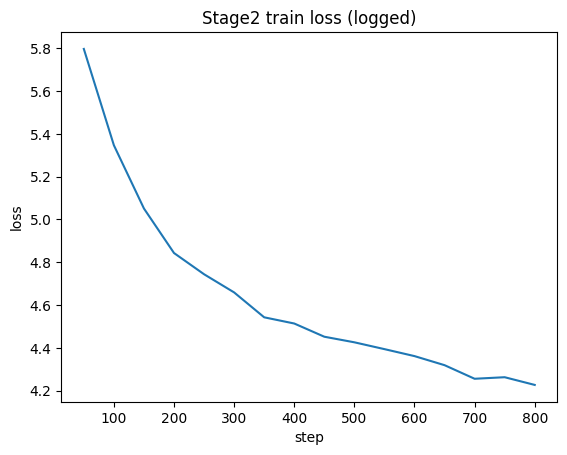

Stage2 last eval BLEU: None


In [ ]:
import matplotlib.pyplot as plt

steps=[]; loss=[]
eval_steps=[]; eval_bleu=[]
for row in ft_log_history:
    if "loss" in row and "step" in row:
        steps.append(row["step"]); loss.append(row["loss"])
    if "eval_bleu" in row and "step" in row:
        eval_steps.append(row["step"]); eval_bleu.append(row["eval_bleu"])

if len(loss)>0:
    plt.figure()
    plt.plot(steps, loss, marker="o")
    plt.title("Stage2 train loss (logged)")
    plt.xlabel("step"); plt.ylabel("loss")
    plt.grid(True, alpha=0.3)
    plt.show()

if len(eval_bleu)>0:
    plt.figure()
    plt.plot(eval_steps, eval_bleu, marker="o")
    plt.title("Stage2 eval BLEU (Multi30k valid during fine-tune)")
    plt.xlabel("step"); plt.ylabel("BLEU")
    plt.grid(True, alpha=0.3)
    plt.show()

stage2_last_logged = eval_bleu[-1] if len(eval_bleu)>0 else None
stage2_valid_after = ft_m30k_valid.get("m30k_valid_bleu") if isinstance(ft_m30k_valid, dict) else None

print("Stage2 last logged eval BLEU (during train, Multi30k valid):", stage2_last_logged)
print("Stage2 final Multi30k valid BLEU (after train):", stage2_valid_after)
print("LEAGUE_FINAL_SCORE_M30K_TEST_BLEU (after fine-tune):", FINAL_TEST_BLEU)


### (추가) Fine-tune 후 Multi30k 번역 예시 시각화
- **목표:** 학습/평가 과정을 눈으로 확인하기 위한 보조 시각화입니다.
- **참고:** 리그전 튜닝은 상단의 `MODEL_HP`(구조)와 `FT_HP`(fine-tune 학습 설정)에서만 진행합니다.


In [38]:
# === (추가) Fine-tune 후 Multi30k 번역 예시 ===
model.eval()
for i in range(3):
    ex = multi30k["validation"][i]
    src_text = ex[SRC_KEY]
    ref_text = ex[TGT_KEY]

    inputs = hf_tokenizer(src_text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)
    gen_ids = model.generate(**inputs, max_length=MAX_LEN, num_beams=4)
    hyp_text = hf_tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print("\n--- example", i, "---")
    print("SRC:", src_text)
    print("REF:", ref_text)
    print("HYP:", hyp_text)



--- example 0 ---
SRC: Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
REF: A group of men are loading cotton onto a truck
HYP: A group of men are going to be a tree in a room .

--- example 1 ---
SRC: Ein Mann schläft in einem grünen Raum auf einem Sofa.
REF: A man sleeping in a green room on a couch.
HYP: A man sleeping in a green room .

--- example 2 ---
SRC: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
REF: A boy wearing headphones sits on a woman's shoulders.
HYP: A boy with her head is sitting on a woman .


### (추가) Cross-attention heatmap (fine-tune 후) 시각화
- **목표:** attention을 heatmap으로 그려서 모델이 **어느 소스 토큰을 참고했는지** 관찰합니다.
- **핵심 로직:**
  - `output_attentions=True`로 forward 실행 → attention 텐서를 얻습니다.
  - 보통 shape는 `(layers, batch, heads, tgt_len, src_len)` 류입니다(모델에 따라 다름).
  - 특정 layer/head를 골라 `imshow`로 시각화합니다.
- **해석 팁:**
  - x축: 소스 토큰 위치(무엇을 봤는지), y축: 타깃 토큰 위치(누가 봤는지)
  - 밝을수록 '그 소스 토큰을 많이 참고'했다는 의미
- **주의:** BPE 토큰은 단어가 쪼개져 보일 수 있어요(예: `play` → `pl` + `ay`).

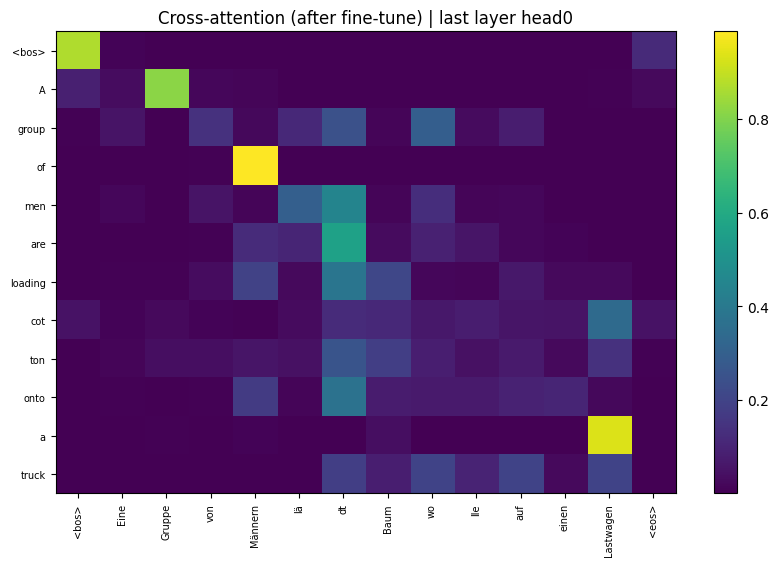

In [ ]:
# === (추가) Cross-attention heatmap (fine-tune 후) ===
import torch, matplotlib.pyplot as plt, numpy as np

model.eval()
model.config.attn_implementation = 'eager'
model.config.output_attentions = True

ex = multi30k["validation"][0]
src_text, tgt_text = ex[SRC_KEY], ex[TGT_KEY]

enc = hf_tokenizer(src_text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)
dec = hf_tokenizer(tgt_text, return_tensors="pt", truncation=True, max_length=MAX_LEN).to(device)
decoder_input_ids = dec["input_ids"][:, :-1]

with torch.no_grad():
    out = model(
        input_ids=enc["input_ids"],
        attention_mask=enc["attention_mask"],
        decoder_input_ids=decoder_input_ids,
        output_attentions=True,
        return_dict=True,
    )

cross = out.cross_attentions
attn = cross[-1][0, 0].detach().cpu().numpy()  # last layer, head0

src_tokens = hf_tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
tgt_tokens = hf_tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

max_src = min(len(src_tokens), 40)
max_tgt = min(len(tgt_tokens), 25)

plt.figure(figsize=(10,6))
plt.imshow(attn[:max_tgt,:max_src], aspect="auto")
plt.colorbar()
plt.xticks(range(max_src), src_tokens[:max_src], rotation=90, fontsize=7)
plt.yticks(range(max_tgt), tgt_tokens[:max_tgt], fontsize=7)
plt.title("Cross-attention (after fine-tune) | last layer head0")
plt.show()

---
## 📌 제작 정보 & 출처

- 제작: 가천대학교 인공지능 학술 동아리 **Aing (A.ing)**

### 사용/참고 자료
- Vaswani et al., **Attention Is All You Need**, NeurIPS 2017.
- A.ing 내부 스터디 자료: *Attention 치트시트*, *Transformer CookBook*.
- HuggingFace Transformers/Datasets 문서: Seq2Seq 학습(Trainer), Multi30k, IWSLT 로딩.
- `tokenizers`(BPE), `sacrebleu`(BLEU 평가) 라이브러리.
